In [35]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing

# Airfoil

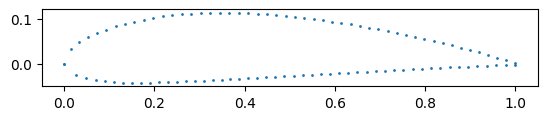

In [36]:
airfoil = af.Airfoil.NACA4("4415", n_points=50)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

alpha0 = -4 * np.pi / 180

# Polar Formulation

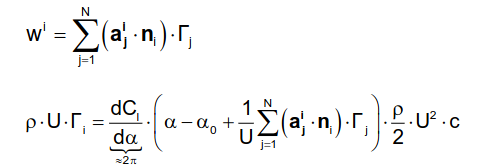

## Wing Geometry

In [37]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)

def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)

## Discretization and Grid Generation

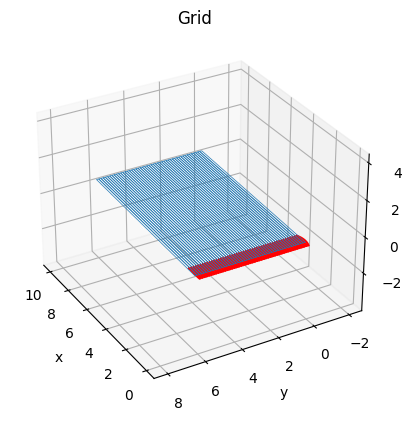

In [38]:
N = 50
M = 2
wg = Wing(
    airfoil=airfoil,
    isSymmetric=True,
    span=6,
    alpha=2,
    beta=0,
    Ni=N,
    Nj=M,
    sweepAngle=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)

## Wind

In [39]:
Umag = 20
dens = 1.2

## Solve

In [40]:
# EQS MATRIX
RHS = np.zeros((N-1)*(M-1))
infMat = np.zeros(((N-1)*(M-1), (N-1)*(M-1)))
a = np.zeros(((N-1)*(M-1), (N-1)*(M-1)))

L_pan = np.zeros((N-1))
D_pan = np.zeros((N-1))

In [45]:
for i in np.arange(0, N-1):
    RHS[i] = np.pi * (wg.alpha - alpha0) * wg.Dchord[i] * Umag
    for j in np.arange(0, N-1):
        k=0
        U = pot.hshoe2((wg.grid[i, 0, 0] + wg.grid[i+1, 0, 0])/2,
                       (wg.grid[i, 0, 1] + wg.grid[i+1, 0, 1])/2,
                       (wg.grid[i, 0, 2] + wg.grid[i+1, 0, 2])/2,
                       j, k, wg.grid)
        a[i, j] = np.dot(wg.nj[i], U)
        infMat[i, j] = - a[i, j] * wg.Dchord[i] * np.pi
    infMat[i, i] = infMat[i, i] + 1

Gammas = np.linalg.solve(infMat, RHS)
w_ind = np.matmul(a, Gammas)

wingArea = 0 
for i in np.arange(0, N-1):
    L_pan[i] = dens * Umag * Gammas[i] * (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])
    D_pan[i] = - dens * w_ind[i] * Gammas[i] * (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1])
    wingArea += (wg.grid[i+1, 0, 1] - wg.grid[i, 0, 1]) * wg.Dchord[i]
L = np.sum(L_pan)
D = np.sum(D_pan)

print(f"L:{L}\t|\tD:{D}")
print(f"CL:{L/(dens*(Umag**2)*wingArea)}\t|\tCD_ind:{D/(dens*(Umag**2)*wingArea)}")


L:695.0968735335723	|	D:17.843848317890412
CL:0.24135308108804593	|	CD_ind:0.006195780665934171


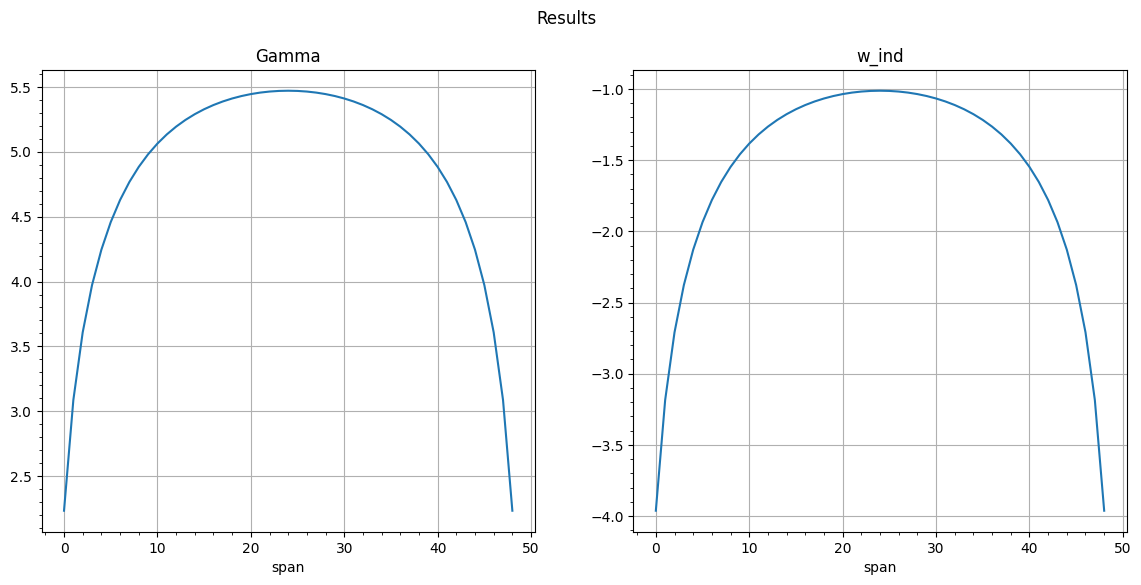

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Results')

ax1.plot(Gammas)
ax1.set_xlabel("span")
ax1.set_title("Gamma")
ax1.minorticks_on()
ax1.grid()

ax2.plot((w_ind/Umag) * 180 / np.pi)
ax2.set_xlabel("span")
ax2.set_title("w_ind")
ax2.minorticks_on()
ax2.grid()
